/tmp/ipykernel_3200483/735920438.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the legend
/tmp/ipykernel_3200483/735920438.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the legend
/tmp/ipykernel_3200483/735920438.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the legend
/tmp/ipykernel_3200483/735920438.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the legend


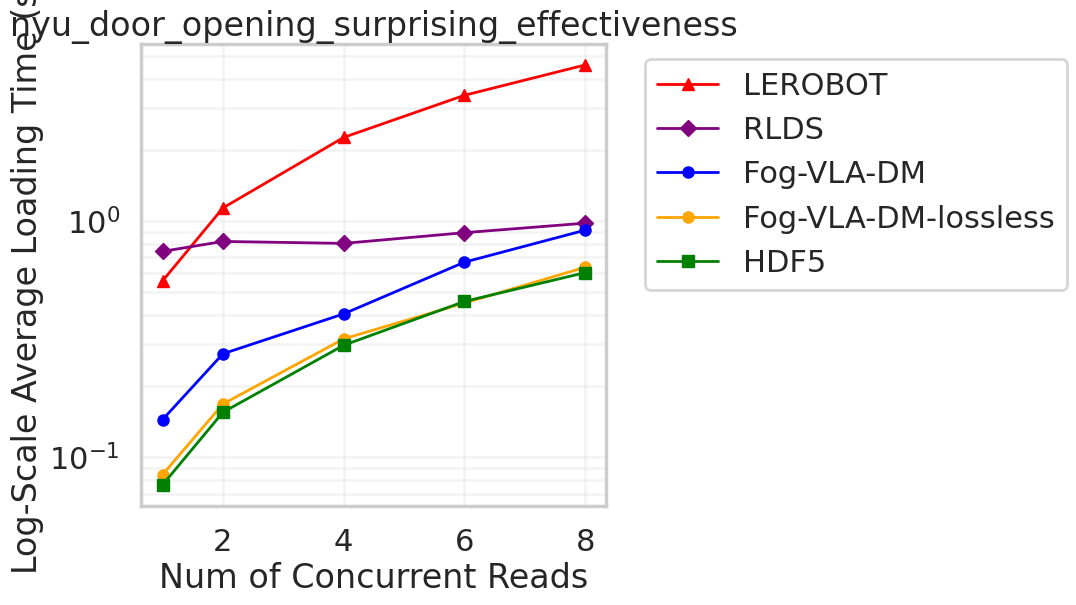

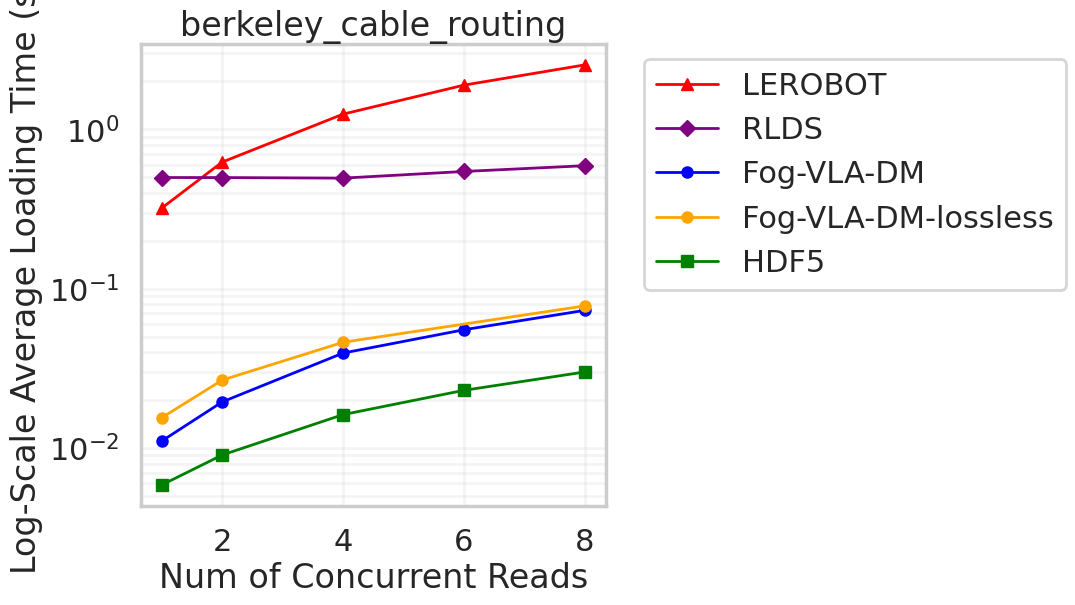

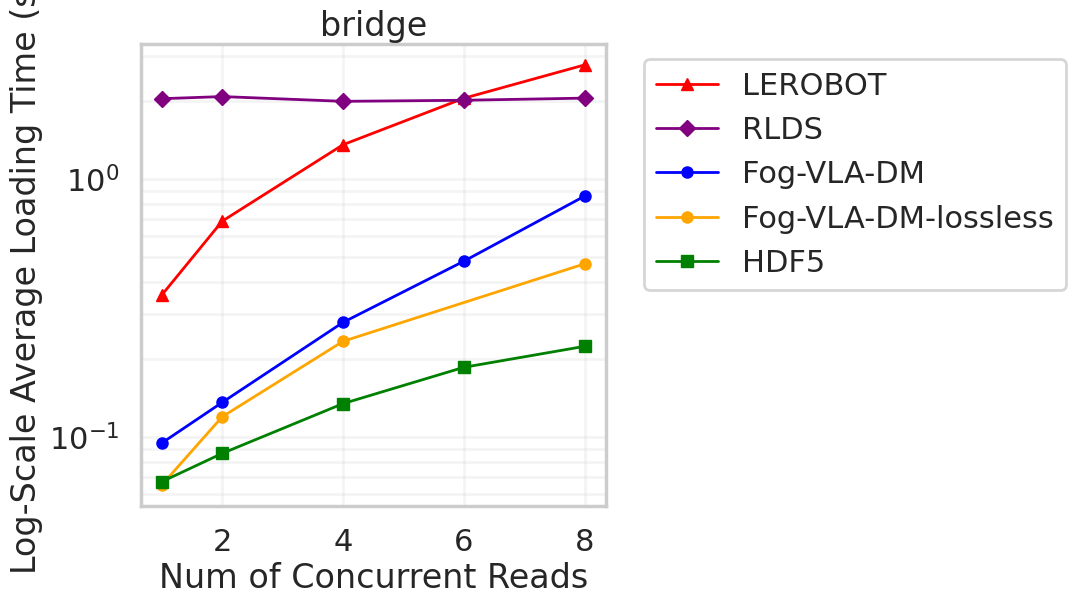

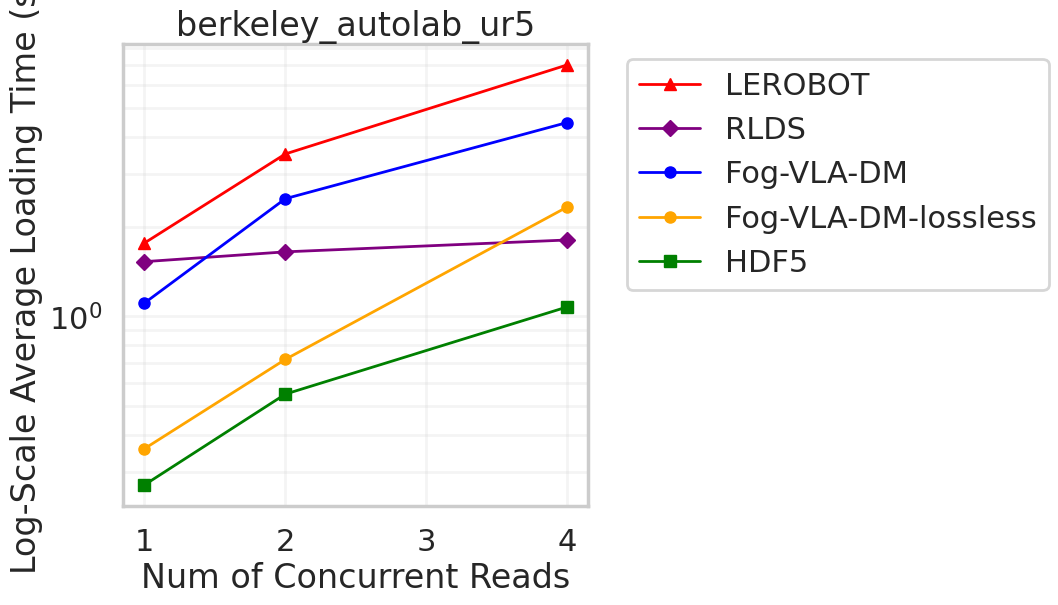

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Define colors and markers for each format
format_styles = {
    'LEROBOT': ('red', '^'),
    'RLDS': ('purple', 'D'),
    'Fog-VLA-DM': ('blue', 'o'),
    "Fog-VLA-DM-lossless": ('orange', 'o'),
    'HDF5': ('green', 's'),
}

# Update the format name from 'VLA' to 'Fog-VLA-DM' in the DataFrame
df['Format'] = df['Format'].replace('VLA', 'Fog-VLA-DM')
df['Format'] = df['Format'].replace('FFV1', 'Fog-VLA-DM-lossless')

# Update the format_styles dictionary
format_styles['Fog-VLA-DM'] = format_styles.pop('VLA', ('blue', 'o'))

# Get unique datasets and batch sizes
datasets = df['Dataset'].unique()

# Create a figure for each dataset
for dataset in datasets:
    plt.figure(figsize=(6, 6))
    
    dataset_df = df[df['Dataset'] == dataset]
    
    # Create the line plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        plt.plot(data['BatchSize'], data['AverageLoadingTime(s)'], 
                 color=color, marker=marker, label=format, linewidth=2, markersize=8)

    # Customize the plot
    # plt.xlabel('Num of Concurrent Reads')
    # plt.ylabel('Log-Scale Average Loading Time (s)')
    plt.title(f'{dataset}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.xscale('log')  # Use log scale for x-axis
    plt.yscale('log')  # Use log scale for y-axis
    plt.tight_layout()  # Adjust layout to make room for the legend
    
    # Add a grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Show the plot
    plt.savefig(f'./{dataset}.pdf')

/tmp/ipykernel_3200483/2817297649.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Dataset', 'BatchSize']).apply(calculate_speedup).reset_index(drop=True)


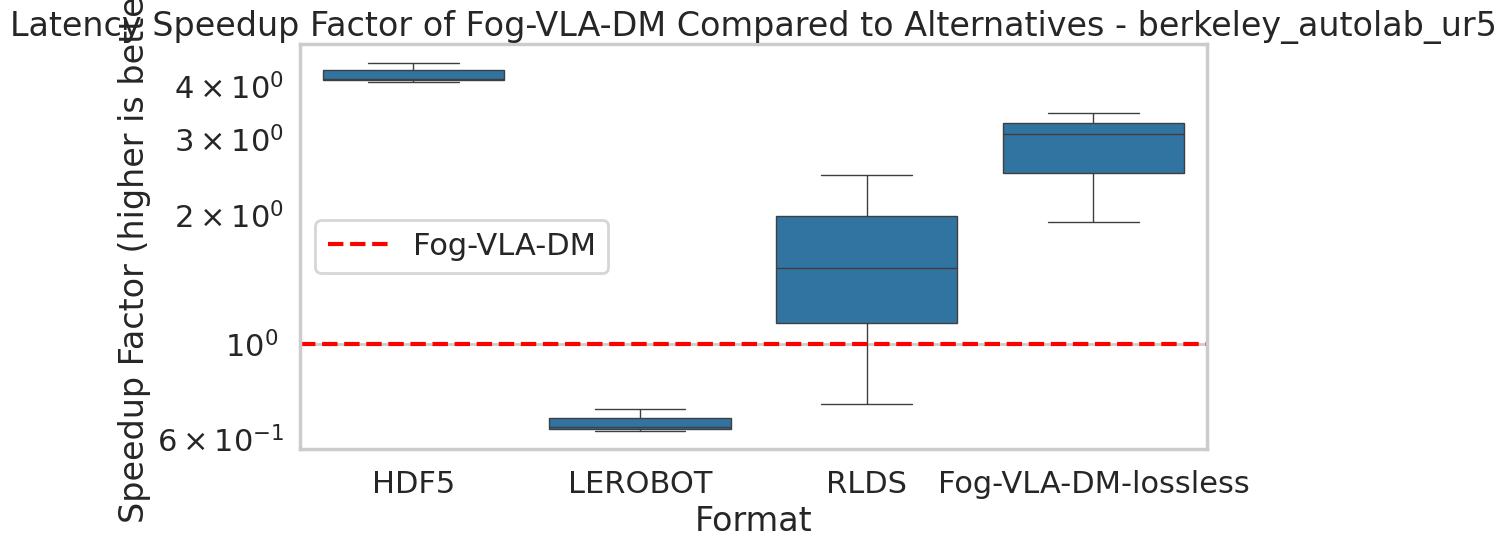


Summary for berkeley_autolab_ur5:
                         mean    median       min       max
Format                                                     
Fog-VLA-DM-lossless  2.824063  3.084723  1.922030  3.465437
HDF5                 4.259725  4.163264  4.081820  4.534092
LEROBOT              0.658879  0.640482  0.628601  0.707555
RLDS                 1.571795  1.508707  0.726021  2.480656

Fog-VLA-DM-lossless:
  On average, Fog-VLA-DM is 2.82x faster
  Median speedup: 3.08x
  Range: 1.92x to 3.47x faster

HDF5:
  On average, Fog-VLA-DM is 4.26x faster
  Median speedup: 4.16x
  Range: 4.08x to 4.53x faster

LEROBOT:
  On average, Fog-VLA-DM is 0.66x faster
  Median speedup: 0.64x
  Range: 0.63x to 0.71x faster

RLDS:
  On average, Fog-VLA-DM is 1.57x faster
  Median speedup: 1.51x
  Range: 0.73x to 2.48x faster


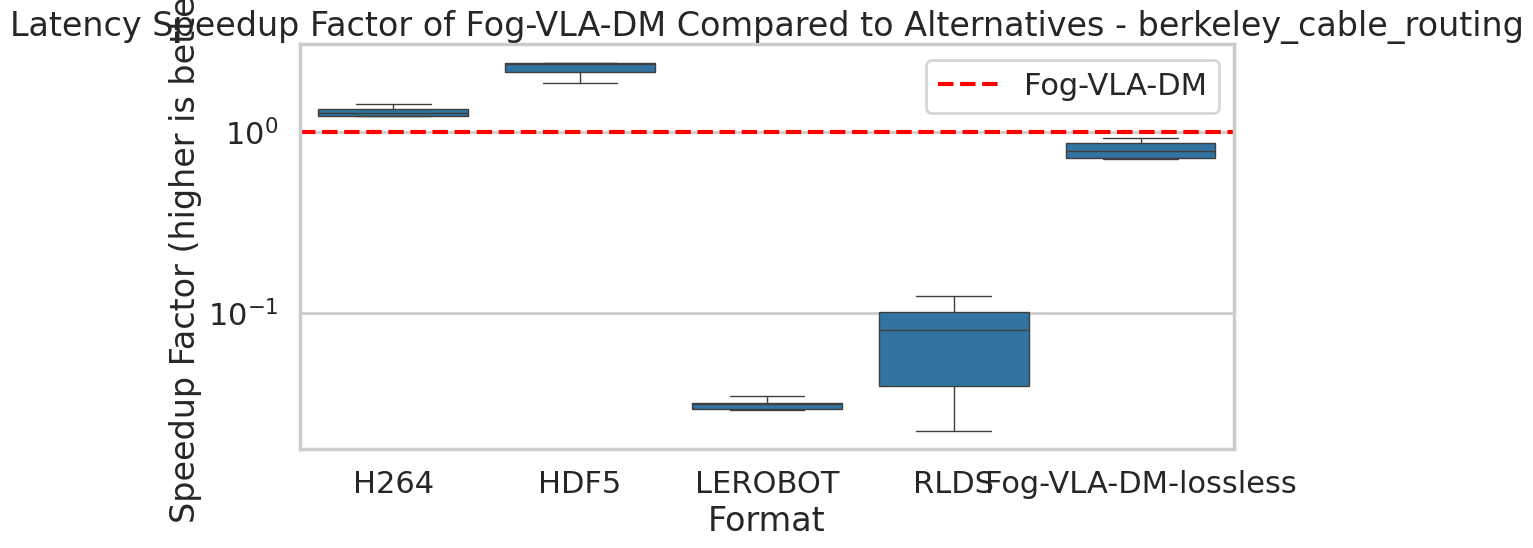


Summary for berkeley_cable_routing:
                         mean    median       min       max
Format                                                     
Fog-VLA-DM-lossless  0.809255  0.792606  0.714179  0.937631
H264                 1.310345  1.283263  1.231549  1.439083
HDF5                 2.261303  2.398626  1.886863  2.435957
LEROBOT              0.031114  0.031281  0.028841  0.034557
RLDS                 0.073306  0.079867  0.022246  0.123708

Fog-VLA-DM-lossless:
  On average, Fog-VLA-DM is 0.81x faster
  Median speedup: 0.79x
  Range: 0.71x to 0.94x faster

H264:
  On average, Fog-VLA-DM is 1.31x faster
  Median speedup: 1.28x
  Range: 1.23x to 1.44x faster

HDF5:
  On average, Fog-VLA-DM is 2.26x faster
  Median speedup: 2.40x
  Range: 1.89x to 2.44x faster

LEROBOT:
  On average, Fog-VLA-DM is 0.03x faster
  Median speedup: 0.03x
  Range: 0.03x to 0.03x faster

RLDS:
  On average, Fog-VLA-DM is 0.07x faster
  Median speedup: 0.08x
  Range: 0.02x to 0.12x faster


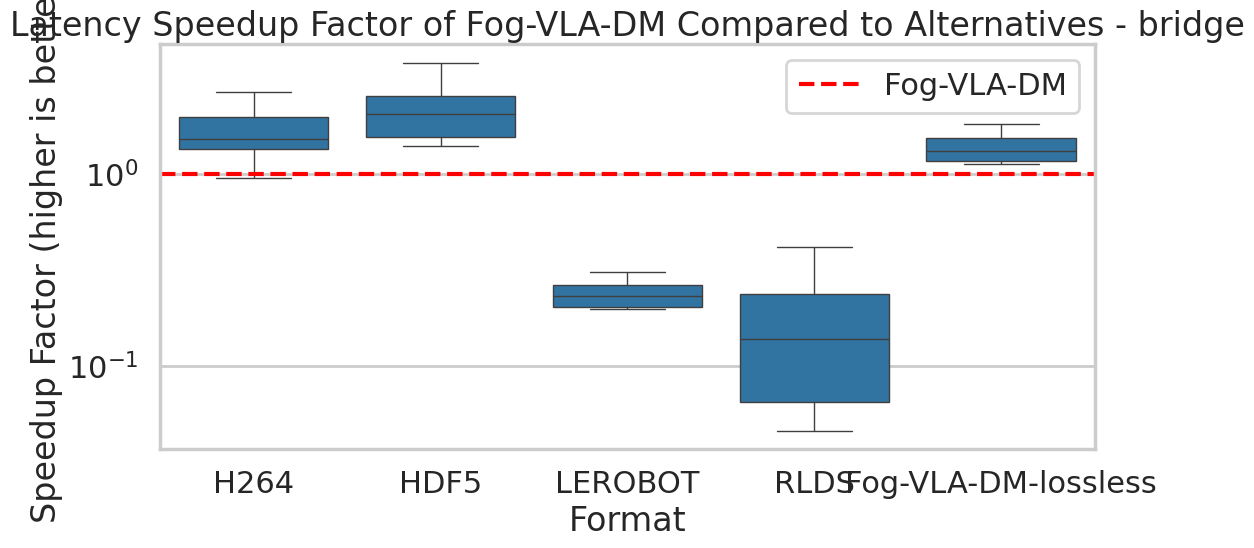


Summary for bridge:
                         mean    median       min       max
Format                                                     
Fog-VLA-DM-lossless  1.401418  1.319205  1.136809  1.830454
H264                 1.708113  1.538449  0.955733  2.698478
HDF5                 2.291325  2.065455  1.412598  3.823695
LEROBOT              0.242532  0.233347  0.198193  0.309825
RLDS                 0.180912  0.138910  0.046215  0.416763

Fog-VLA-DM-lossless:
  On average, Fog-VLA-DM is 1.40x faster
  Median speedup: 1.32x
  Range: 1.14x to 1.83x faster

H264:
  On average, Fog-VLA-DM is 1.71x faster
  Median speedup: 1.54x
  Range: 0.96x to 2.70x faster

HDF5:
  On average, Fog-VLA-DM is 2.29x faster
  Median speedup: 2.07x
  Range: 1.41x to 3.82x faster

LEROBOT:
  On average, Fog-VLA-DM is 0.24x faster
  Median speedup: 0.23x
  Range: 0.20x to 0.31x faster

RLDS:
  On average, Fog-VLA-DM is 0.18x faster
  Median speedup: 0.14x
  Range: 0.05x to 0.42x faster


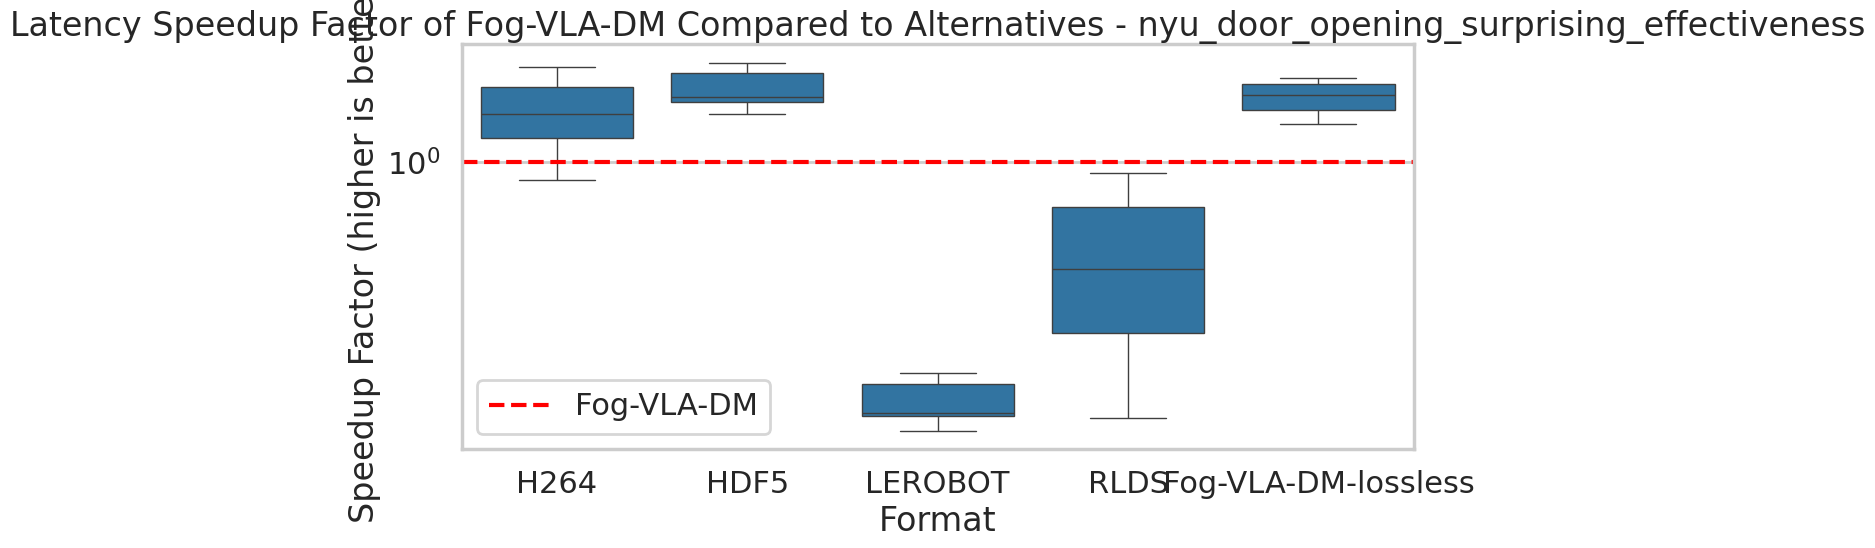


Summary for nyu_door_opening_surprising_effectiveness:
                         mean    median       min       max
Format                                                     
Fog-VLA-DM-lossless  1.512650  1.533295  1.275668  1.708343
H264                 1.374171  1.363077  0.893099  1.833454
HDF5                 1.598478  1.512395  1.357568  1.887998
LEROBOT              0.215221  0.199928  0.179151  0.258760
RLDS                 0.543318  0.503186  0.194050  0.934344

Fog-VLA-DM-lossless:
  On average, Fog-VLA-DM is 1.51x faster
  Median speedup: 1.53x
  Range: 1.28x to 1.71x faster

H264:
  On average, Fog-VLA-DM is 1.37x faster
  Median speedup: 1.36x
  Range: 0.89x to 1.83x faster

HDF5:
  On average, Fog-VLA-DM is 1.60x faster
  Median speedup: 1.51x
  Range: 1.36x to 1.89x faster

LEROBOT:
  On average, Fog-VLA-DM is 0.22x faster
  Median speedup: 0.20x
  Range: 0.18x to 0.26x faster

RLDS:
  On average, Fog-VLA-DM is 0.54x faster
  Median speedup: 0.50x
  Range: 0.19x to 0.93

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Update the format names
df['Format'] = df['Format'].replace('VLA', 'Fog-VLA-DM')
df['Format'] = df['Format'].replace('FFV1', 'Fog-VLA-DM-lossless')

# Calculate speedup factors
def calculate_speedup(group):
    fog_vla_dm_time = group[group['Format'] == 'Fog-VLA-DM']['AverageLoadingTime(s)'].values[0]
    group['SpeedupFactor'] = fog_vla_dm_time / group['AverageLoadingTime(s)']
    return group

df = df.groupby(['Dataset', 'BatchSize']).apply(calculate_speedup).reset_index(drop=True)

# Get unique datasets
datasets = df['Dataset'].unique()

# Create a plot for each dataset
for dataset in datasets:
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Filter data for the current dataset
    dataset_df = df[df['Dataset'] == dataset]
    
    # Create the box plot
    sns.boxplot(x='Format', y='SpeedupFactor', data=dataset_df[dataset_df['Format'] != 'Fog-VLA-DM'])
    
    # Customize the plot
    plt.title(f'Latency Speedup Factor of Fog-VLA-DM Compared to Alternatives - {dataset}')
    plt.xlabel('Format')
    plt.ylabel('Speedup Factor (higher is better)')
    plt.yscale('log')
    
    # Add a horizontal line at y=1 to represent Fog-VLA-DM
    plt.axhline(y=1, color='r', linestyle='--', label='Fog-VLA-DM')
    
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'latency_speedup_comparison_{dataset}.pdf')
    plt.show()
    
    # Print summary statistics for the current dataset
    summary = dataset_df[dataset_df['Format'] != 'Fog-VLA-DM'].groupby('Format')['SpeedupFactor'].agg(['mean', 'median', 'min', 'max'])
    print(f"\nSummary for {dataset}:")
    print(summary)
    
    # Print interpretation of the summary
    for format, stats in summary.iterrows():
        print(f"\n{format}:")
        print(f"  On average, Fog-VLA-DM is {stats['mean']:.2f}x faster")
        print(f"  Median speedup: {stats['median']:.2f}x")
        print(f"  Range: {stats['min']:.2f}x to {stats['max']:.2f}x faster")

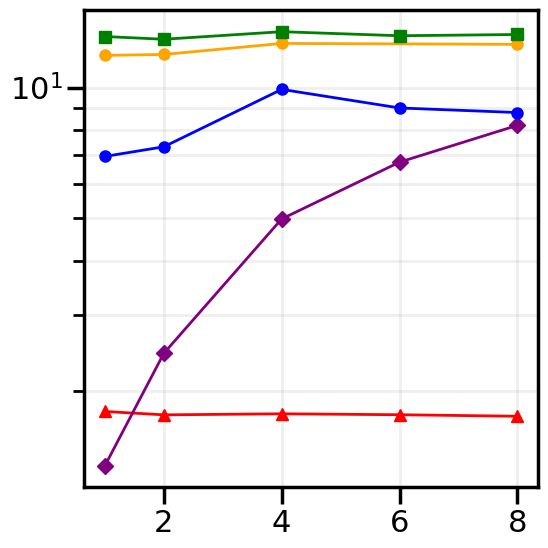

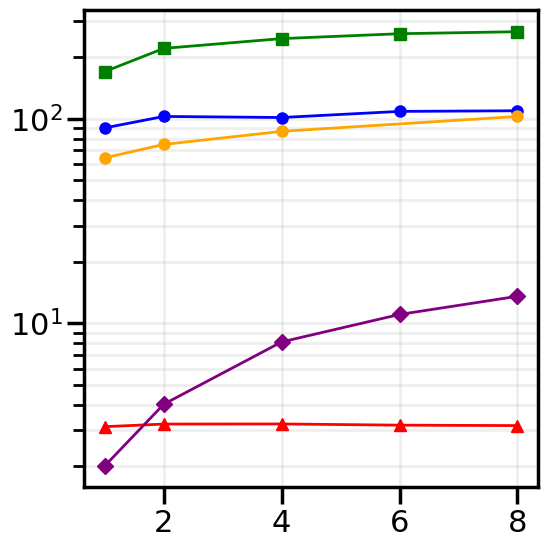

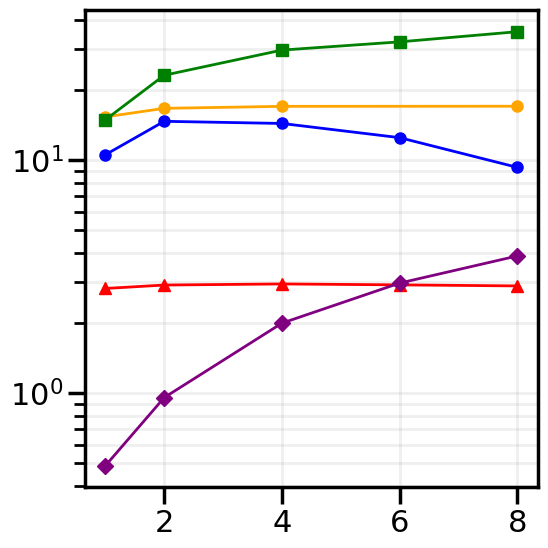

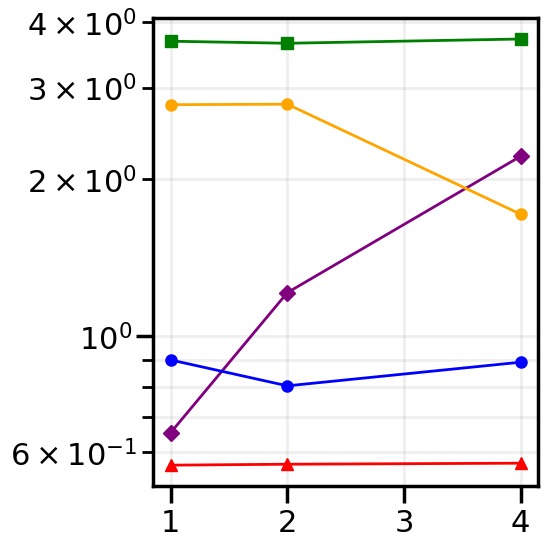

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Define colors and markers for each format
format_styles = {
    'LEROBOT': ('red', '^'),
    'RLDS': ('purple', 'D'),
    'Fog-VLA-DM': ('blue', 'o'),
    "Fog-VLA-DM-lossless": ('orange', 'o'),
    'HDF5': ('green', 's'),
}

# Update the format name from 'VLA' to 'Fog-VLA-DM' in the DataFrame
df['Format'] = df['Format'].replace('VLA', 'Fog-VLA-DM')
df['Format'] = df['Format'].replace('FFV1', 'Fog-VLA-DM-lossless')

# Update the format_styles dictionary
format_styles['Fog-VLA-DM'] = format_styles.pop('VLA', ('blue', 'o'))

# Get unique datasets and batch sizes
datasets = df['Dataset'].unique()

# Create a figure for each dataset
for dataset in datasets:
    plt.figure(figsize=(6, 6))
    
    dataset_df = df[df['Dataset'] == dataset]
    
    # Create the line plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        # Calculate throughput: (1 / loading time) * batch size
        throughput = (1 / data['AverageLoadingTime(s)']) * data['BatchSize']
        plt.plot(data['BatchSize'], throughput, 
                 color=color, marker=marker, label=format, linewidth=2, markersize=8)

    # Customize the plot
    # plt.xlabel('Num of Concurrent Reads')
    # plt.ylabel('Throughput (trajectories/s)')
    # plt.title(f'{dataset}')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.xscale('log')  # Use /log scale for x-axis
    plt.yscale('log')  # Use log scale for y-axis
    plt.tight_layout()  # Adjust layout to make room for the legend
    
    # Add a grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Show the plot
    plt.savefig(f'./{dataset}_throughput.pdf')
    plt.show()

# ... (rest of the existing code remains unchanged) ...

In [2]:
# Update RLDS and LEROBOT average trajectory sizes
rlds_sizes = {
    'berkeley_cable_routing': 3.23,
    'bridge': 15.58,
    'nyu_door_opening_surprising_effectiveness': 16.76
}

lerobot_sizes = {
    'berkeley_cable_routing': 0.68,
    'bridge': 0.31,
    'nyu_door_opening_surprising_effectiveness': 0.88
}

# Update the DataFrame
for dataset in rlds_sizes.keys():
    df.loc[(df['Dataset'] == dataset) & (df['Format'] == 'RLDS'), 'AverageTrajectorySize(MB)'] = rlds_sizes[dataset]
    df.loc[(df['Dataset'] == dataset) & (df['Format'] == 'LEROBOT'), 'AverageTrajectorySize(MB)'] = lerobot_sizes[dataset]

# Verify the changes
print(df[df['Format'].isin(['RLDS', 'LEROBOT'])][['Dataset', 'Format', 'AverageTrajectorySize(MB)']])

                                      Dataset   Format  \
2   nyu_door_opening_surprising_effectiveness  LEROBOT   
3   nyu_door_opening_surprising_effectiveness     RLDS   
6   nyu_door_opening_surprising_effectiveness  LEROBOT   
7   nyu_door_opening_surprising_effectiveness     RLDS   
10  nyu_door_opening_surprising_effectiveness  LEROBOT   
11  nyu_door_opening_surprising_effectiveness     RLDS   
14  nyu_door_opening_surprising_effectiveness  LEROBOT   
15  nyu_door_opening_surprising_effectiveness     RLDS   
18  nyu_door_opening_surprising_effectiveness  LEROBOT   
19  nyu_door_opening_surprising_effectiveness     RLDS   
22                     berkeley_cable_routing  LEROBOT   
23                     berkeley_cable_routing     RLDS   
26                                     bridge  LEROBOT   
27                                     bridge     RLDS   
30                       berkeley_autolab_ur5  LEROBOT   
31                       berkeley_autolab_ur5     RLDS   
34            

In [3]:
# Calculate relative file size for each dataset
results = []

for dataset in df['Dataset'].unique():
    dataset_df = df[df['Dataset'] == dataset]
    
    vla_size = dataset_df[dataset_df['Format'] == 'Fog-VLA-DM']['AverageTrajectorySize(MB)'].mean()
    
    for format in ['Fog-VLA-DM', 'RLDS', 'HDF5', 'LEROBOT', 'Fog-VLA-DM-lossless']:
        format_size = dataset_df[dataset_df['Format'] == format]['AverageTrajectorySize(MB)'].mean()
        relative_size = format_size / vla_size if vla_size != 0 else float('inf')
        
        results.append({
            'Dataset': dataset,
            'Format': format,
            'AverageTrajectorySize(MB)': format_size,
            'RelativeSize': relative_size
        })

results_df = pd.DataFrame(results)

# Pivot the results for easier reading
pivot_df = results_df.pivot_table(values=['AverageTrajectorySize(MB)', 'RelativeSize'], 
                                  index='Dataset', 
                                  columns='Format', 
                                  fill_value='-')

# Display the results
print("File Size (MB):")
print(pivot_df['AverageTrajectorySize(MB)'].to_string(float_format='{:.2f}'.format))
print("\nRelative Size (compared to Fog-VLA-DM):")
print(pivot_df['RelativeSize'].to_string(float_format='{:.2f}'.format))

File Size (MB):
Format                                     Fog-VLA-DM  Fog-VLA-DM-lossless   HDF5  LEROBOT  RLDS
Dataset                                                                                         
berkeley_autolab_ur5                             1.85                25.57 281.55     0.00  0.00
berkeley_cable_routing                           0.18                 1.10   4.87     0.68  3.23
bridge                                           0.21                 4.40  29.91     0.31 15.58
nyu_door_opening_surprising_effectiveness        0.23                 5.78  79.54     0.88 16.76

Relative Size (compared to Fog-VLA-DM):
Format                                     Fog-VLA-DM  Fog-VLA-DM-lossless   HDF5  LEROBOT  RLDS
Dataset                                                                                         
berkeley_autolab_ur5                             1.00                13.80 152.03     0.00  0.00
berkeley_cable_routing                           1.00                 

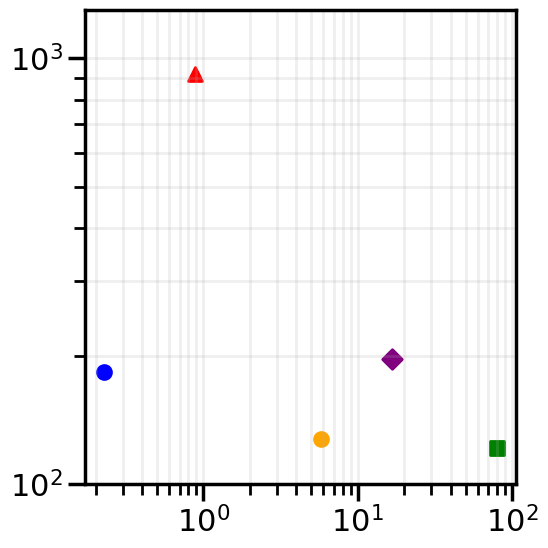

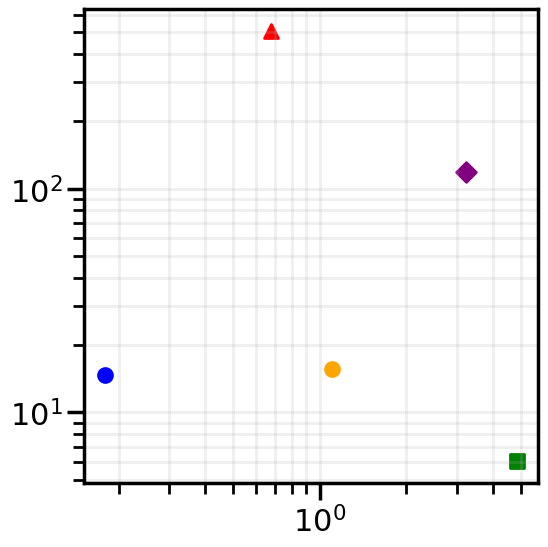

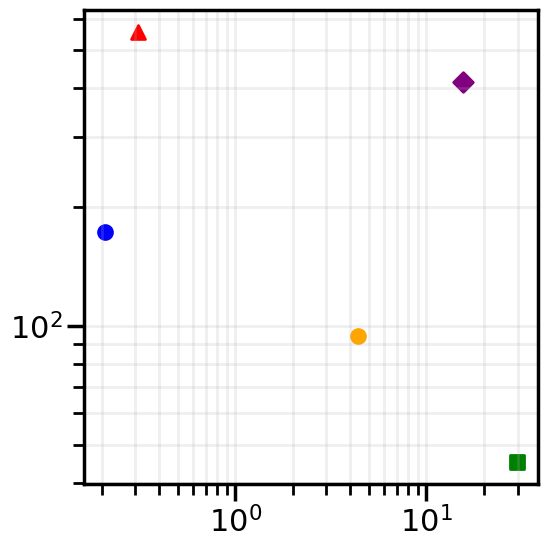

In [17]:
# Filter the data for batch size 8
batch_8_df = df[df['BatchSize'] == 8]

# Get unique datasets
datasets = batch_8_df['Dataset'].unique()

# Create a figure for each dataset
for dataset in datasets:
    plt.figure(figsize=(6, 6))
    
    dataset_df = batch_8_df[batch_8_df['Dataset'] == dataset]
    
    # Create the scatter plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        plt.scatter(data['AverageTrajectorySize(MB)'], data['LoadingTime(s)'], 
                    color=color, marker=marker, label=format, s=100)
        
        # Add labels for each point
        # for _, row in data.iterrows():
        #     if format == 'LEROBOT':
        #         plt.annotate(format, (row['AverageTrajectorySize(MB)'], row['LoadingTime(s)']),
        #                      xytext=(-40, -40), textcoords='offset points', ha='left', va='bottom')
        #     elif format == 'RLDS':
        #         # move to the left a little bit
        #         plt.annotate(format, (row['AverageTrajectorySize(MB)'], row['LoadingTime(s)']),
        #                      xytext=(-10, 10), textcoords='offset points', ha='left', va='bottom')
        #     elif format == 'HDF5':
        #         plt.annotate(format, (row['AverageTrajectorySize(MB)'], row['LoadingTime(s)']),
        #                      xytext=(-80, -10), textcoords='offset points', ha='left', va='bottom')
        #     elif format == 'Fog-VLA-DM-lossless':
        #         # move to very left 
        #         plt.annotate(format, (row['AverageTrajectorySize(MB)'], row['LoadingTime(s)']),
        #                      xytext=(-80, 10), textcoords='offset points', ha='left', va='bottom')
        #     else:
        #         plt.annotate(format, (row['AverageTrajectorySize(MB)'], row['LoadingTime(s)']),
        #                      xytext=(5, 5), textcoords='offset points', ha='left', va='bottom')

    # Customize the plot
    # plt.xlabel('Average Trajectory Size (MB)')
    # plt.ylabel('Loading Time (s)')
    # plt.title(f'{dataset} - Trajectory Size vs Loading Time (Batch Size 8)')
    # plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    # for nyu_door_opening_surprising_effectiveness, move the x axis to the left
    if dataset == 'nyu_door_opening_surprising_effectiveness':
        plt.ylim(100, 1300)
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'./{dataset}_cost_vs_time.pdf')
    plt.show()

In [5]:
import pandas as pd

data = {
    'Dataset': ['Cable Routing', 'Door Opening', 'AutoLab UR5', 'Bridge'],
    'RLDS': [4.67, 7.12, 76.39, 387.49],
    'HDF5': [7.38, 35.35, 258.33, 779.24],
    'Fog-VLA-DM-lossless': [1.67, 2.89, 23.45, 114.63],
    'LEROBOT': [0.36, 0.38, None, 16.34],
    'Fog-VLA-DM': [0.26, 0.10, 3.26, 5.31]
}

df_melted = pd.DataFrame(data)

# Melt the DataFrame to have format and size as separate columns
df_melted = df_melted.melt(id_vars=['Dataset'], var_name='Format', value_name='Size (GB)')

# Sort the DataFrame by Dataset and Format
df_melted = df_melted.sort_values(['Dataset', 'Format'])

print(df_melted)

          Dataset               Format  Size (GB)
18    AutoLab UR5           Fog-VLA-DM       3.26
10    AutoLab UR5  Fog-VLA-DM-lossless      23.45
6     AutoLab UR5                 HDF5     258.33
14    AutoLab UR5              LEROBOT        NaN
2     AutoLab UR5                 RLDS      76.39
19         Bridge           Fog-VLA-DM       5.31
11         Bridge  Fog-VLA-DM-lossless     114.63
7          Bridge                 HDF5     779.24
15         Bridge              LEROBOT      16.34
3          Bridge                 RLDS     387.49
16  Cable Routing           Fog-VLA-DM       0.26
8   Cable Routing  Fog-VLA-DM-lossless       1.67
4   Cable Routing                 HDF5       7.38
12  Cable Routing              LEROBOT       0.36
0   Cable Routing                 RLDS       4.67
17   Door Opening           Fog-VLA-DM       0.10
9    Door Opening  Fog-VLA-DM-lossless       2.89
5    Door Opening                 HDF5      35.35
13   Door Opening              LEROBOT       0.38


Datasets in df_melted: ['AutoLab UR5' 'Bridge' 'Cable Routing' 'Door Opening']
Datasets in batch_8_df: ['nyu_door_opening_surprising_effectiveness' 'berkeley_cable_routing'
 'bridge']


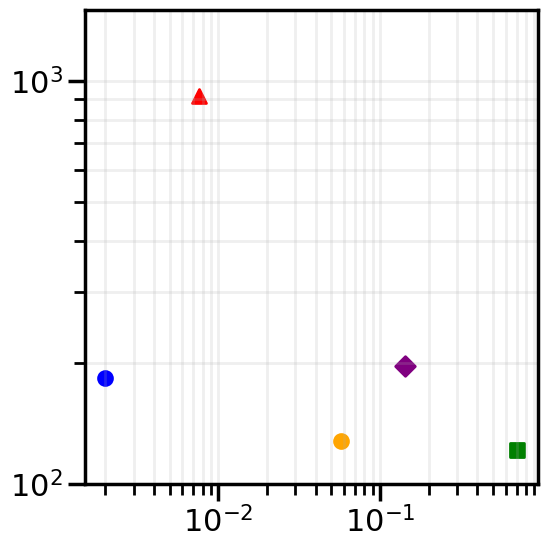

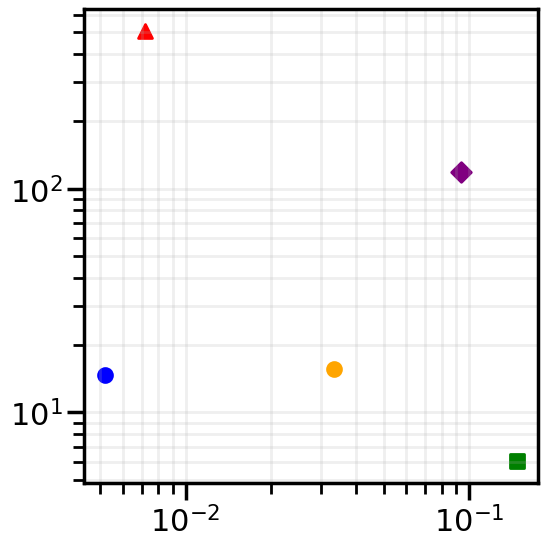

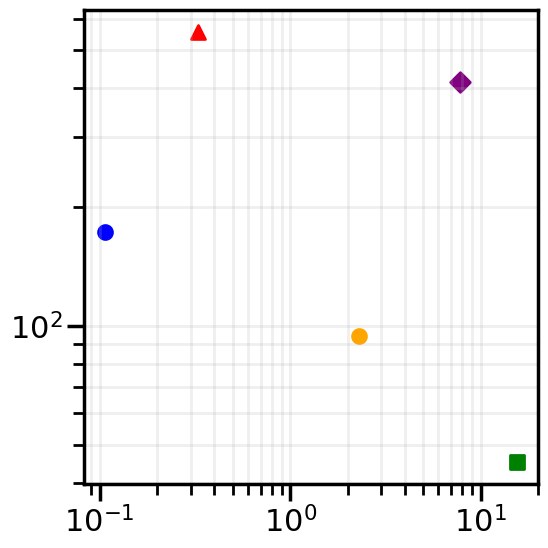

In [32]:
# Assuming df_melted and df are already created as in the previous code

# Print unique dataset names in both DataFrames
print("Datasets in df_melted:", df_melted['Dataset'].unique())
print("Datasets in batch_8_df:", batch_8_df['Dataset'].unique())

# Filter the data for batch size 8
batch_8_df = df[df['BatchSize'] == 8]

# Get unique datasets
datasets = batch_8_df['Dataset'].unique()

# Create a mapping between dataset names if necessary
dataset_mapping = {
    'berkeley_cable_routing': 'Cable Routing',
    'nyu_door_opening_surprising_effectiveness': 'Door Opening',
    'bridge': 'Bridge'
    # Add more mappings if needed
}

# use the same color for the same format
color_mapping = {
    'RLDS': 'purple',
    'HDF5': 'green',
    'Fog-VLA-DM-lossless': 'orange',
    'LEROBOT': 'red',
    'Fog-VLA-DM': 'blue'
}

# Create a figure for each dataset
for dataset in datasets:
    plt.figure(figsize=(6, 6))
    
    dataset_df = batch_8_df[batch_8_df['Dataset'] == dataset]
    
    # Map the dataset name if necessary
    mapped_dataset = dataset_mapping.get(dataset, dataset)
    
    # Create the scatter plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        try:
            size = df_melted[(df_melted['Dataset'] == mapped_dataset) & (df_melted['Format'] == format)]['Size (GB)'].values[0]
            plt.scatter(size * 0.02, data['LoadingTime(s)'], 
                        color=color_mapping[format], marker=marker, label=format, s=100)
        except IndexError:
            print(f"Warning: No data found for dataset '{mapped_dataset}' and format '{format}'")
            continue

    # Customize the plot
    # plt.xlabel('Dataset Size (GB)')
    # plt.ylabel('Throughput (episodes/s)')
    # plt.title(f'{mapped_dataset} - Dataset Size vs Loading Time (Batch Size 8)')
    # plt.legend()
    
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.grid(True, which="both", ls="-", alpha=0.2)

    if mapped_dataset == 'Door Opening':
        plt.ylim(100, 1500)
    # Show the plot
    plt.tight_layout()
    plt.savefig(f'./{mapped_dataset}_size_vs_cost_overall.pdf')
    plt.show()

/tmp/ipykernel_3200483/808706995.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Dataset', 'BatchSize']).apply(calculate_speedup).reset_index(drop=True)


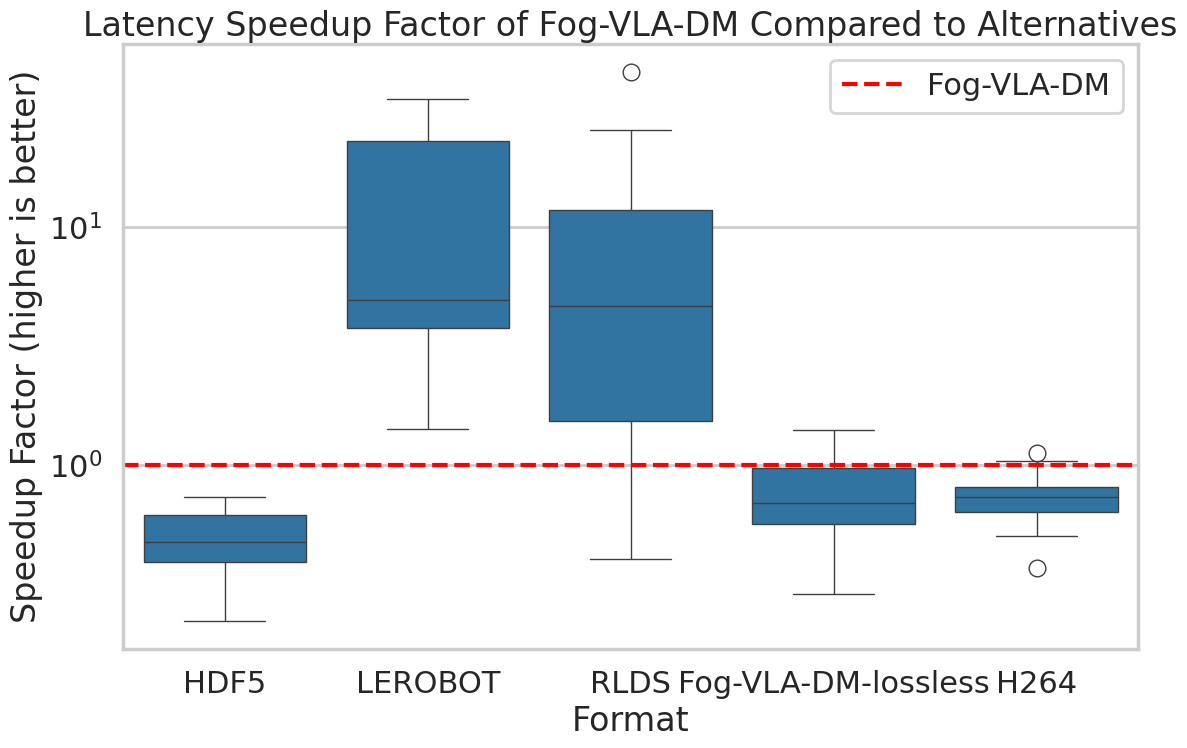

                          mean    median       min        max
Format                                                       
Fog-VLA-DM-lossless   0.785081  0.696694  0.288564   1.400209
H264                  0.733893  0.734583  0.370579   1.119697
HDF5                  0.477196  0.474345  0.220551   0.736611
LEROBOT              11.711865  4.944148  1.413318  34.672886
RLDS                  9.262323  4.681807  0.403119  44.951988


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Update the format names
df['Format'] = df['Format'].replace('VLA', 'Fog-VLA-DM')
df['Format'] = df['Format'].replace('FFV1', 'Fog-VLA-DM-lossless')

# Calculate speedup factors
def calculate_speedup(group):
    fog_vla_dm_time = group[group['Format'] == 'Fog-VLA-DM']['AverageLoadingTime(s)'].values[0]
    group['SpeedupFactor'] = group['AverageLoadingTime(s)'] / fog_vla_dm_time
    return group

df = df.groupby(['Dataset', 'BatchSize']).apply(calculate_speedup).reset_index(drop=True)

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the box plot
sns.boxplot(x='Format', y='SpeedupFactor', data=df[df['Format'] != 'Fog-VLA-DM'])

# Customize the plot
plt.title('Latency Speedup Factor of Fog-VLA-DM Compared to Alternatives')
plt.xlabel('Format')
plt.ylabel('Speedup Factor (higher is better)')
plt.yscale('log')

# Add a horizontal line at y=1 to represent Fog-VLA-DM
plt.axhline(y=1, color='r', linestyle='--', label='Fog-VLA-DM')

plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('latency_speedup_comparison.pdf')
plt.show()

# Print summary statistics
summary = df[df['Format'] != 'Fog-VLA-DM'].groupby('Format')['SpeedupFactor'].agg(['mean', 'median', 'min', 'max'])
print(summary)